# Exercise 1 - Building a Decision Tree

First, we need to load in our dataset. We will be using the `spotifyclassification` (available [here](https://www.kaggle.com/datasets/geomack/spotifyclassification)) for this exercise.

Use the "Add Input" button in the panel on the right to make these datasets available to your notebook. If you have successfully added these datasets, then running the cell below should print the path you can use to load them in.

In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotifyclassification/data.csv


The cell below imports some packages that we will use for building and evaluating our models.

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## Reading in the data

Okay, we're ready to get started. Let's load in our first dataset and take a look at it!

In [102]:
spotify_df = pd.read_csv("/kaggle/input/spotifyclassification/data.csv", index_col=0)
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


The dataset contains a number of features of songs from 2017 available on Spotify, and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0).

These are *one* user's listening preferences. We will investigate whether the features Spotify provides are helpful in predicting whether or not a user likes a particular song.

---
### Questions: 
1. Look up the documentation of the features [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Which ones do you think are likely to help with predicting our **target** column? Which ones are best discarded?

2. Is this is supervised, unsupervised or self-supervised machine learning problem? Do we want to perform inference or prediction?

---

## Data Splitting

As always, our first task should be to split our data into a training and test set. We will not access the test data until the very end, when we are ready to evaluate our final trained model.

In [103]:
# Split the data

train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)

We can check how many data points our training and test sets contain

In [104]:
n_train_samples = train_df.shape[0]
n_test_samples = test_df.shape[0]

print(f"Training Examples: {n_train_samples}")
print(f"Test Examples: {n_test_samples}")

Training Examples: 1613
Test Examples: 404


Pandas also allows us to conveniently calculate some summary statistics for our dataset. For example, we can check what the mean and standard deviation for our numerical columns is.

In [105]:
# Summary statistics

spotify_summary = train_df.describe()
spotify_summary

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


## Exploratory Data Analysis

We will first try to understand our dataset by examining some features directly. The code below produces histograms for the `loudness` feature using pandas plotting. The histograms show the distribution of the feature values in the training set, separated for positive (target=1, i.e., user liked the song) and negative (target=0, i.e., user disliked the song) examples.

There are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other.

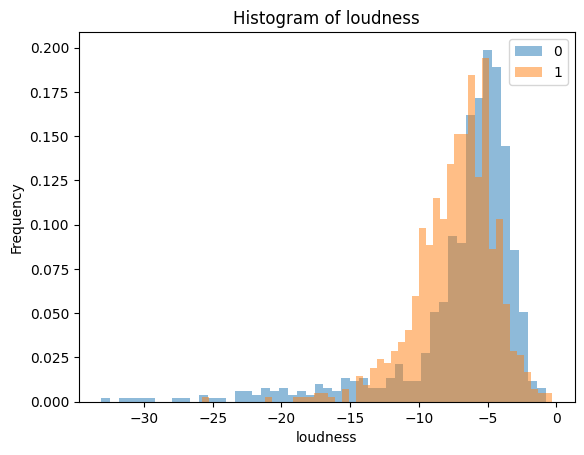

In [106]:
# Plotting the loudness feature

feat = "loudness"
train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat);
plt.xlabel(feat);


The histogram shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

---
## Question:

Suppose we were to build a decision tree using only the `loudness` feature. What would a good decision tree look like? What threshold values is our model likely to learn? How deep should we make our tree?

---

## More plotting

The code below makes similar plots for some other features-- specifically `acousticness`, `danceability`, `tempo`, `energy` and `valence`. Run the cell and examine the histograms generated. Feel free to include more features in the list to be plotted.

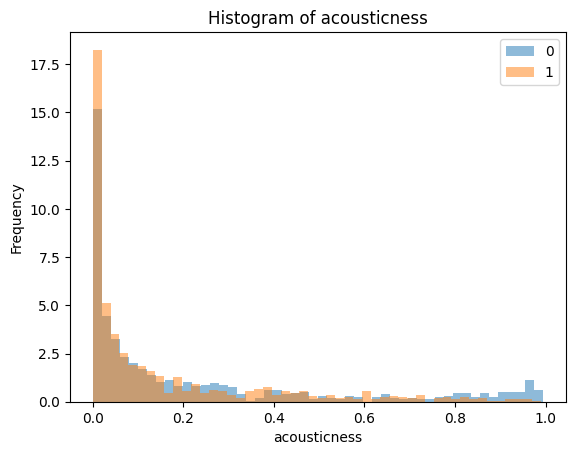

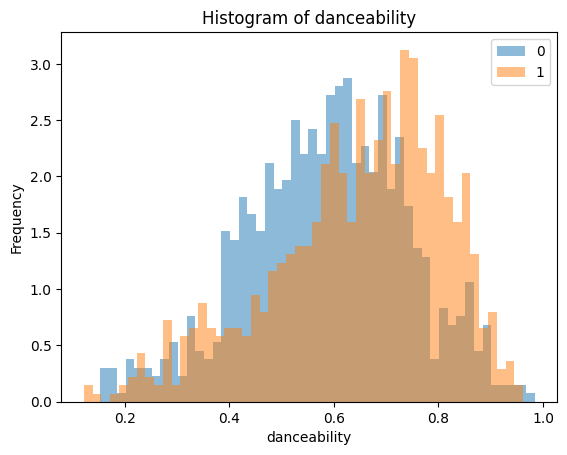

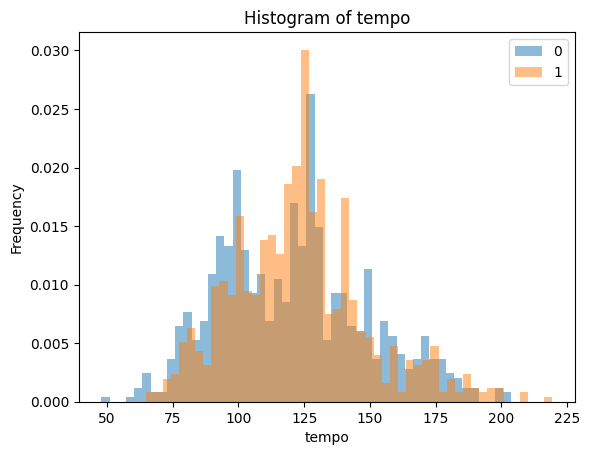

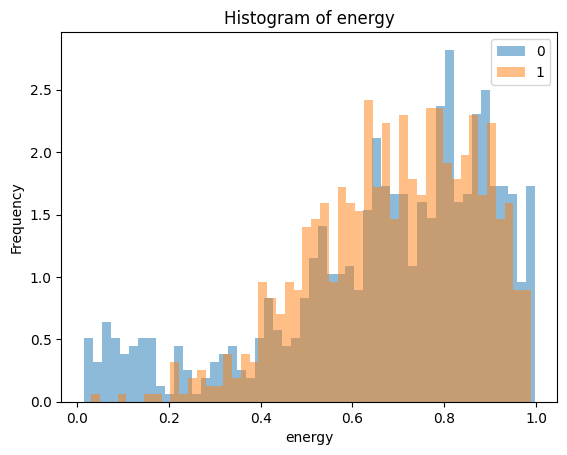

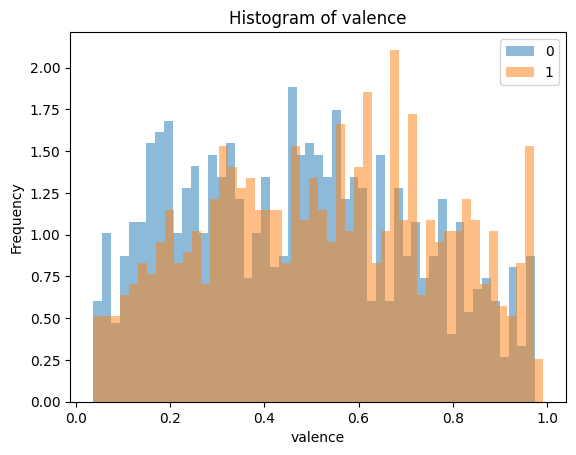

In [107]:
features = [
    "acousticness",
    "danceability",
    "tempo",
    "energy",
    "valence",
]
for feat in features:
    ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title="Histogram of " + feat)
    plt.xlabel(feat)
    plt.show()


---
## Question:

Some features (like `tempo`) seem to have a similar distribution between both target classes (0 and 1). Should we drop these features from our data, based onthe histograms we plotted?

---

We are going to drop `song_title` and `artist` since they are text features. (Do you expect either feature to be useful?)

We are also separating the features from the target.

In [108]:
X_train = train_df.drop(columns=["target", "song_title", "artist"])
y_train = train_df["target"]

X_test = test_df.drop(columns=["target", "song_title", "artist"])
y_test = test_df["target"]

## Dummy Classifier

First, we train a dummy classifier. This gives us a baseline prediction against which to compare our model performance.

The dummy classifier predicts the same value of the target for all examples in the training set. When we call `fit()`, our dummy classifier learns the most common value of the target. The function `score()` then predicts this value for all examples, and returns the proportion which were correctly predicted. So the value returned here is the proportion of examples that belong to the most common target class.

In [109]:
# Dummy Classifier

dummy = DummyClassifier(random_state=123)
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5077495350278983

Looks like a balanced dataset! We have a close to 50-50 split between the target classes. Any ML model that actually learned useful information should perform with an accuracy higher than 50%.

We are now ready to build our decision tree.

In [110]:
# Creating a decision tree

spotify_tree = DecisionTreeClassifier(random_state=123)

Let's train and score our tree.

In [111]:
spotify_tree.fit(X_train, y_train)
spotify_tree.score(X_train, y_train)

0.9993800371977681

That score is *very* high. Our model is classifying training examples with near-perfect accuracy! 

---
#### Question:

Do we trust our training scores to give a good prediction for model performance on unseen data? Have we built a good model?

---

## Examining our model

Let's see how deep the fitted decision tree looks.

In [112]:
spotify_tree.get_depth()

17

---
### Question:

You should see a decision tree of depth 17. How many distinct training examples could a depth 17 decision tree memorize? How many examples exist in our dataset?

---

It would be good to know what features our tree thought were important! Let's visualize the first few nodes.

In [113]:
# Training with just depth 3

three_model = DecisionTreeClassifier(max_depth=3, random_state=123)
three_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

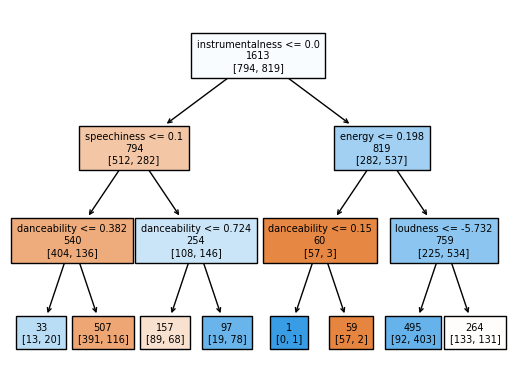

In [114]:
# Plotting

plot_tree(three_model, filled=True, 
               feature_names = X_train.columns.to_list(),
               impurity = False,
               fontsize = 7,
               label = None);

___

### Question:

What features do you see the tree using? Do they match the features you expected to see based on the histograms in your EDA?

___

Our model achieved a near-perfect training score. However, since we trained on all data in our training set, we have not yet been able to measure model performance on new, unseen data.

Let's check how well our trained model does on the test set.

In [115]:
spotify_tree.score(X_test, y_test)

0.6881188118811881

Hmmm. That wasn't nearly as good. We went from perfect predictions on training data to only 68% accuracy on test data. It is likely that we have overfit.

## Finding a better model

We fit a very deep decision tree that likely just memorized our dataset. A shallower tree might limit some of the overfitting, so let's try forcing a maximum depth on our tree.

In [116]:
new_model = DecisionTreeClassifier(max_depth=5, random_state=123)

We train and score this model as usual on the training set.

In [117]:
new_model.fit(X_train, y_train)
new_model.score(X_train, y_train)

0.7885926844389337

We get a lower training score than before. But what about test score?

In [118]:
new_model.score(X_test, y_test)

0.7178217821782178

There's still some overfitting, but we're getting a better test score than what we got before (with a deeper, more complex decision tree!) Also, there is less of a gap between our training and test scores, so our model is generalizating reasonably to new data, and making sensible predictions.

## Hold on... did we violate the Golden Rule?

We used our test set twice, which means we violated the Golden Rule of Machine Learning. In practice, it is *not* a good idea to use our test set multiple times with different models. The more often we use it, the less certain we can be of our model's predictions out in the real world. We might start overfitting to test data, even though we don't use it to directly update model parameters.

This is a real danger, and can lead us to picking bad models.

___
### Question:

If re-using the test set is bad, but we cannot evaluate model performance until we measure it on unseen data, how are we to select good values for hyperparameters or choose between models?

How do we find the best `max_depth` for modelling our Spotify data?

___

Hyperparameter tuning is generally carried out using **cross-validation**. Essentially, this involves setting aside part of your training data as a 'validation set' to be used *only* for testing (and not for fitting each individual model). Then, validation accuracy can be used as a proxy for test accuracy.

Sklearn has many helper functions to make cross-validation easy (see [here](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)).

## Feature Importance

Sklearn also has a built-in function to tell you which features the decision tree *thinks* are most important for making predictions (based on its learning).

In [125]:
impt = new_model.feature_importances_
for i, f in enumerate(X_train.columns.to_list()):
    print(f"{f}: ", round(impt[i], 4))

acousticness:  0.051
danceability:  0.1133
duration_ms:  0.0497
energy:  0.1683
instrumentalness:  0.2669
key:  0.0
liveness:  0.0
loudness:  0.1181
mode:  0.0
speechiness:  0.1276
tempo:  0.0227
time_signature:  0.0
valence:  0.0825


## Food for thought... (Bonus Question)

The code below takes the "index" column of this dataset and allows us to use it as a feature. What might be the result of using the index as a feature for this dataset?

In [119]:
X_train_2 = X_train.reset_index()

In [120]:
index_model = DecisionTreeClassifier(random_state=123)
index_model.fit(X_train_2, y_train)

DecisionTreeClassifier(random_state=123)

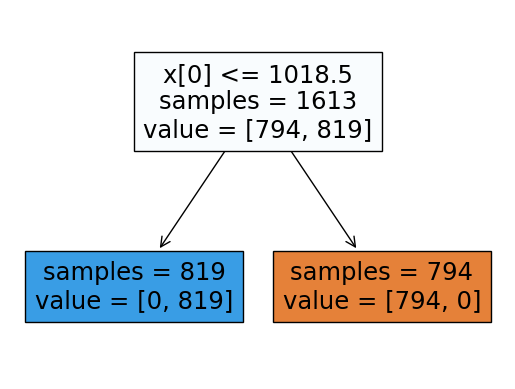

In [121]:
plot_tree(index_model, impurity=False, filled=True);

That's a very simple tree... what happened?